# Extended Kalman Filter initilal Parameters:

In [243]:
import numpy as np
%matplotlib inline
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from scipy.stats import norm
from sympy import Symbol, symbols, Matrix, sin, cos
from sympy import init_printing
init_printing(use_latex=True)

In [244]:
#Total state variables
numstates=4 

In [245]:
vs, psis, dts, xs, ys, lats, lons = symbols('v \phi a_t x y lat lon')

gs = Matrix([[xs+vs*dts*cos(psis)],
             [ys+vs*dts*sin(psis)],
             [psis],
             [vs]])
state = Matrix([xs,ys,psis,vs])

In [246]:
#dynamic fuction:
gs

⎡aₜ⋅v⋅cos(\phi) + x⎤
⎢                  ⎥
⎢aₜ⋅v⋅sin(\phi) + y⎥
⎢                  ⎥
⎢       \phi       ⎥
⎢                  ⎥
⎣        v         ⎦

In [247]:
#State vector Sk = [x,y,phi,v]
state

⎡ x  ⎤
⎢    ⎥
⎢ y  ⎥
⎢    ⎥
⎢\phi⎥
⎢    ⎥
⎣ v  ⎦

In [248]:
# Calculating the Jacoian Jg 
gs.jacobian(state)

⎡1  0  -aₜ⋅v⋅sin(\phi)  aₜ⋅cos(\phi)⎤
⎢                                   ⎥
⎢0  1  aₜ⋅v⋅cos(\phi)   aₜ⋅sin(\phi)⎥
⎢                                   ⎥
⎢0  0         1              0      ⎥
⎢                                   ⎥
⎣0  0         0              1      ⎦

It has to be computed on every filter step because it consists of state variables!

In [249]:
P = np.eye(numstates)*1000.0
print(P, P.shape)

[[1000.    0.    0.    0.]
 [   0. 1000.    0.    0.]
 [   0.    0. 1000.    0.]
 [   0.    0.    0. 1000.]] (4, 4)


## Measurements:

In [250]:
data = 'drone_data.csv'

millis, \
latitude, \
longitude, \
altitude, \
velocity, \
heading = np.loadtxt(data, delimiter=',', unpack= True, skiprows = 1)

print('Read \'%s\' successfully.' % data)



Read 'drone_data.csv' successfully.


In [251]:
heading = (-heading)

### Calculate `dt` (time-steps) for Measurements 

In [252]:
dt = np.hstack([0.02, np.diff(millis)])/1000.0 # in s

In [253]:
hs = Matrix([[xs],
             [ys]])
hs

⎡x⎤
⎢ ⎥
⎣y⎦

In [254]:
JHs=hs.jacobian(state)
JHs

⎡1  0  0  0⎤
⎢          ⎥
⎣0  1  0  0⎦

If no GPS measurement is available, simply set the corresponding values in $J_h$ to zero.

In [255]:
varGPS = 6.0 # Standard Deviation of GPS Measurement
Rk = np.diag([varGPS**2.0, varGPS**2.0])

print(Rk, Rk.shape)

[[36.  0.]
 [ 0. 36.]] (2, 2)


## Identity Matrix

In [256]:
I = np.eye(numstates)
print(I, I.shape)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] (4, 4)


## Approx. Lat/Lon to Meters to check Location

In [257]:
RadiusEarth = 6378388.0 # m
arc= 2.0*np.pi*(RadiusEarth+altitude)/360.0 # m/°

dx = arc * np.cos(latitude*np.pi/180.0) * np.hstack((0.0, np.diff(longitude))) # in m
dy = arc * np.hstack((0.0, np.diff(latitude))) # in m

mx = np.cumsum(dx)
my = np.cumsum(dy)

ds = np.sqrt(dx**2+dy**2)

GPS=(ds!=0.0).astype('bool') # GPS Trigger for Kalman Filter

## Initial State

In [258]:
x = np.matrix([[mx[5], my[10], 0.5*np.pi, 0.0]]).T
print(x, x.shape)

[[-0.00380552]
 [-0.00890594]
 [ 1.57079633]
 [ 0.        ]] (4, 1)


###  Measurement vector

In [259]:
measurements = np.vstack((mx, my))
# Lenth of the measurement
m = measurements.shape[1]
print(measurements.shape)

(2, 12017)


In [260]:
# Preallocation for Plotting
x0, x1, x2, x3 = [], [], [], []
Zx, Zy = [], []
Px, Py, Pdx, Pdy = [], [], [], []
Kx, Ky, Kdx, Kdy = [], [], [], []

def savestates(x, Z, P, K):
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))    
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))

# Extended Kalman Filter solution:

In [261]:
for filterstep in range(m):
    
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    # see "Dynamic Matrix"
    x[0] = x[0] + dt[filterstep]*x[3]*np.cos(x[2])
    x[1] = x[1] + dt[filterstep]*x[3]*np.sin(x[2])
    x[2] = (x[2]+ np.pi) % (2.0*np.pi) - np.pi
    x[3] = x[3]
    
    # Calculate the Jacobian of the Dynamic Matrix A
    # see "Calculate the Jacobian of the Dynamic Matrix with respect to the state vector"
    a13 = -dt[filterstep]*x[3]*np.sin(x[2])
    a14 = dt[filterstep]*np.cos(x[2])
    a23 = dt[filterstep]*x[3]*np.cos(x[2])
    a24 = dt[filterstep]*np.sin(x[2])
    JA = np.matrix([[1.0, 0.0, a13, a14],
                    [0.0, 1.0, a23, a24],
                    [0.0, 0.0, 1.0, 0.0],
                    [0.0, 0.0, 0.0, 1.0]])
    
    
    # Calculate the Process Noise Covariance Matrix
    sGPS     = 0.5*8.8*dt[filterstep]**2  # assume 8.8m/s2 as maximum acceleration
    sCourse  = 2.0*dt[filterstep] # assume 0.5rad/s as maximum turn rate
    sVelocity= 35.0*dt[filterstep] # assume 8.8m/s2 as maximum acceleration

    Qk = np.diag([sGPS**2, sGPS**2, sCourse**2, sVelocity**2])
    
    # Project the error covariance ahead
    P = JA*P*JA.T + Qk
    P = P.astype(np.float64)
    # Measurement Update (Correction)
    # ===============================
    # Measurement Function
    hx = np.matrix([[float(x[0])],
                    [float(x[1])]])

    if GPS[filterstep]: # with 10Hz, every 5th step
        JH = np.matrix([[1.0, 0.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0, 0.0]])
    else: # every other step
        JH = np.matrix([[0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0]])        
    
    Ck = JH*P*JH.T + Rk
    Ck = Ck.astype(np.float64)
    
    K = (P*JH.T) * np.linalg.inv(Ck)
    K = K.astype(np.float64)

    # Update the estimate via
    Z = measurements[:,filterstep].reshape(JH.shape[0],1)
    y = Z - (hx)                         # Innovation or Residual
    x = x + (K*y)

    # Update the error covariance
    P = (I - (K*JH))*P

    # Save states for Plotting
    savestates(x, Z, P, K)

C:\Users\singh\anaconda3\lib\site-packages\numpy\matrixlib\defmatrix.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr = N.array(data, dtype=dtype, copy=copy)


In [262]:
def plotx():
    fig = plt.figure(figsize=(16,16))

    plt.subplot(311)
    plt.step(range(len(measurements[0])),x0-mx[0], label='$x$')
    plt.step(range(len(measurements[0])),x1-my[0], label='$y$')

    plt.title('Extended Kalman Filter State Estimates (State Vector $x$)')
    plt.legend(loc='best',prop={'size':22})
    plt.ylabel('Position (relative to start) [m]')

    plt.subplot(312)
    plt.step(range(len(measurements[0])),x2, label='$\psi$')
    plt.step(range(len(measurements[0])),
             (heading/180.0*np.pi+np.pi)%(2.0*np.pi) - np.pi,
             label='$\psi$ (from GPS as reference)')
    plt.ylabel('Heading')
    plt.legend(loc='best',prop={'size':16})

    plt.subplot(313)
    plt.step(range(len(measurements[0])),x3, label='$v$')
    plt.step(range(len(measurements[0])),velocity/3.6,
             label='$v$ (from GPS as reference)')
    plt.ylabel('Velocity')
    #plt.ylim([0, 30])
    plt.legend(loc='best',prop={'size':16})
    plt.xlabel('Filter Step')

    plt.savefig('Extended-Kalman-Filter-CHCV-State-Estimates.png',
                dpi=72, transparent=True, bbox_inches='tight')

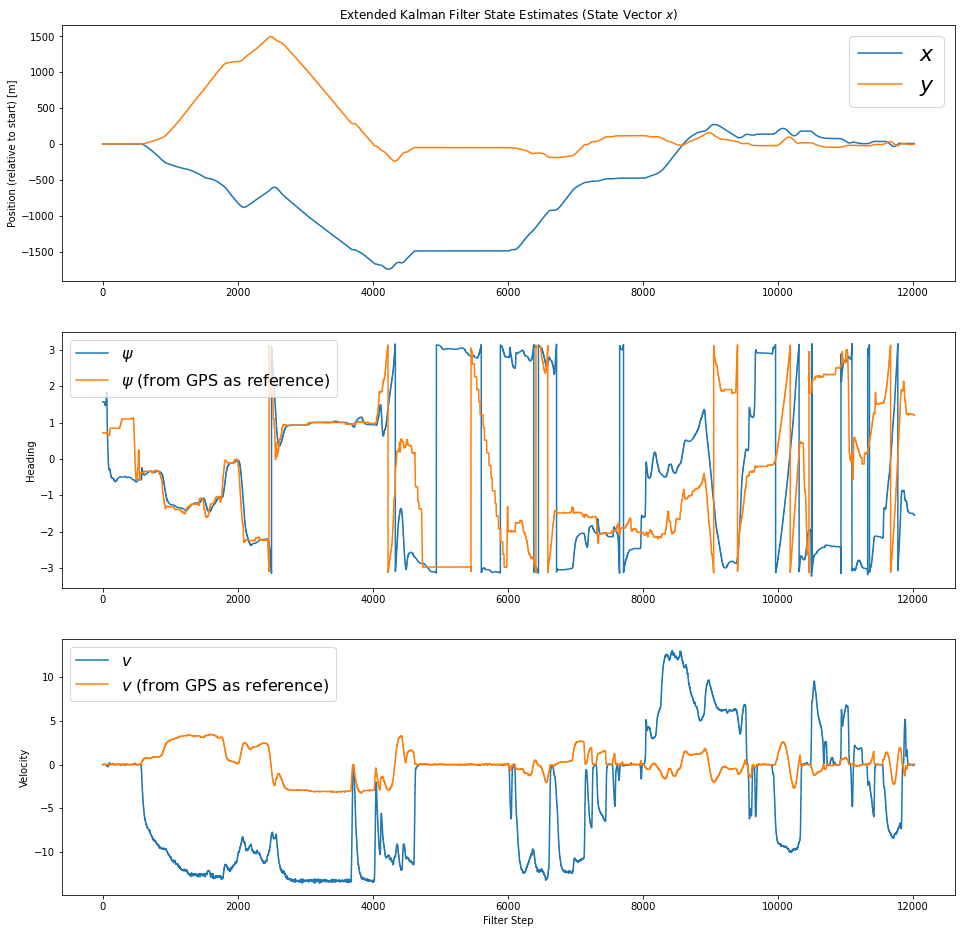

In [263]:
plotx()

In [264]:
def plotxy():

    fig = plt.figure(figsize=(16,9))

    # EKF State
    plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600',
               units='xy', width=0.05, scale=0.5)
    plt.scatter(x0,x1, label='EKF Position', c='g', lw=5)

    # Measurements
    plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements', marker='+')
    #cbar=plt.colorbar(ticks=np.arange(20))
    #cbar.ax.set_ylabel(u'EPE', rotation=270)
    #cbar.ax.set_xlabel(u'm')


    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.title('Position')
    plt.legend(loc='best')
    plt.axis('equal')
    #plt.tight_layout()
    plt.grid()
    plt.savefig('Extended-Kalman-Filter-CHCV-Position.png',
                dpi=72, transparent=True, bbox_inches='tight')

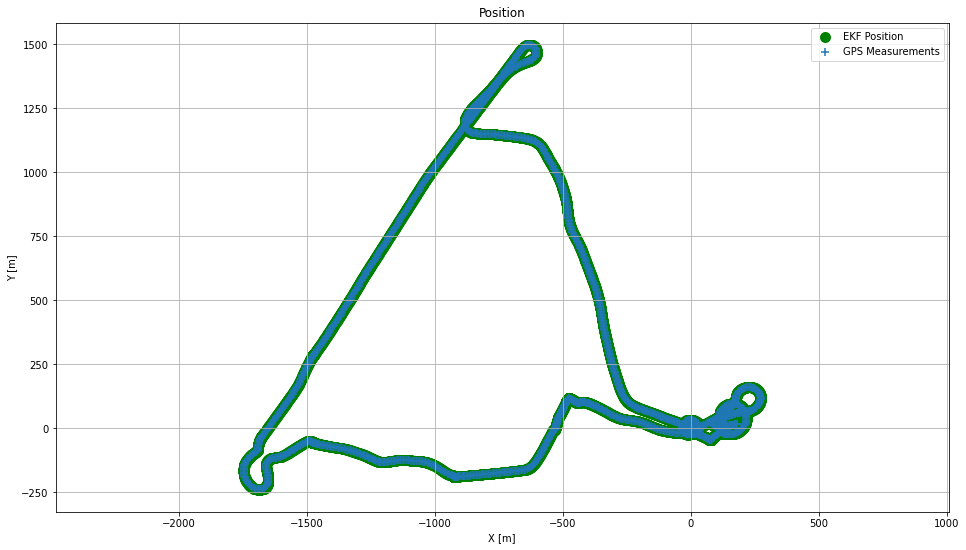

In [265]:
plotxy()

In [266]:
def plotxydetails():
    fig = plt.figure(figsize=(12,9))

    plt.subplot(221)
    # EKF State
    #plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
    plt.plot(x0,x1, label='EKF Position', c='g', lw=5)

    # Measurements
    plt.scatter(mx[::5],my[::5], s=100, label='GPS Measurements', alpha=0.5, marker='+')
    #cbar=plt.colorbar(ticks=np.arange(20))
    #cbar.ax.set_ylabel(u'EPE', rotation=270)
    #cbar.ax.set_xlabel(u'm')

    plt.xlabel('X [m]')
    plt.xlim(70, 130)
    plt.ylabel('Y [m]')
    plt.ylim(140, 200)
    plt.title('Position')
    plt.legend(loc='best')


    plt.subplot(222)

    # EKF State
    #plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
    plt.plot(x0,x1, label='EKF Position', c='g', lw=1, marker = '*')

    # Measurements
    plt.scatter(mx[::5],my[::5], s=100, label='GPS Measurements', alpha=0.5, marker='+')
    #cbar=plt.colorbar(ticks=np.arange(20))
    #cbar.ax.set_ylabel(u'EPE', rotation=270)
    #cbar.ax.set_xlabel(u'm')

    plt.xlabel('X [m]')
    plt.xlim(0, 260)
    plt.ylabel('Y [m]')
    plt.ylim(0, 160)
    plt.title('Position')
    plt.grid()
    plt.legend(loc='best')

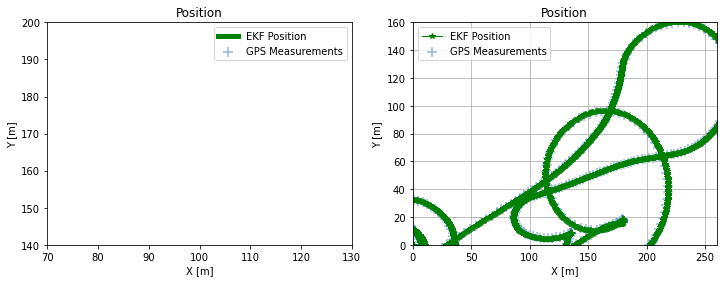

In [267]:
plotxydetails()

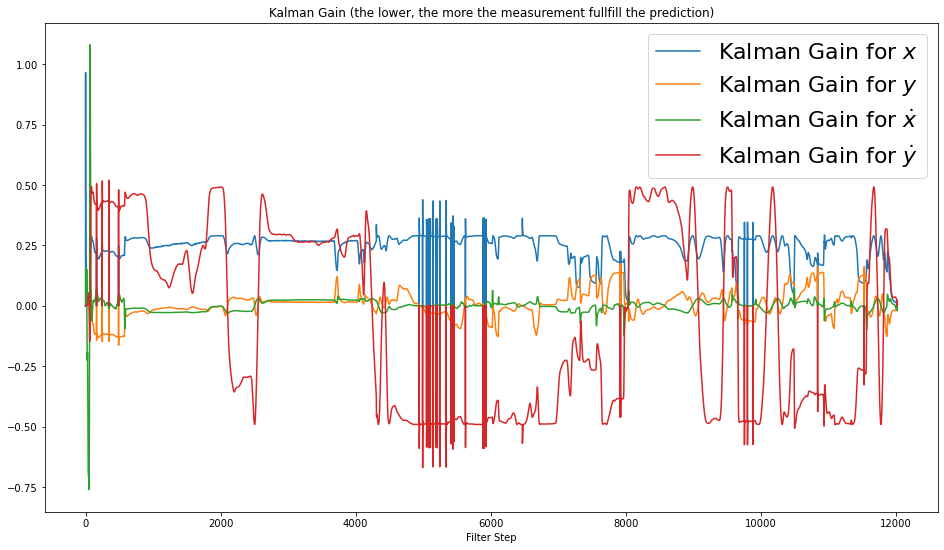

In [268]:
def plot_K():
    fig = plt.figure(figsize=(16,9))
    plt.plot(range(len(measurements[0])),Kx, label='Kalman Gain for $x$')
    plt.plot(range(len(measurements[0])),Ky, label='Kalman Gain for $y$')
    plt.plot(range(len(measurements[0])),Kdx, label='Kalman Gain for $\dot x$')
    plt.plot(range(len(measurements[0])),Kdy, label='Kalman Gain for $\dot y$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
    plt.legend(loc='best',prop={'size':22})

plot_K()